# Hospital Length of Stay Prediction 

This notebook explores the task of predicting the length of hospital stay based on demographic and medical information about patients. The following dataset is used: 

https://microsoft.github.io/r-server-hospital-length-of-stay/input_data.html

## 0. Setup 

In [20]:
!pip install gradio
!pip install shap


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
# imports 
import pandas as pd
import gradio as gr 
import numpy as np
import matplotlib.pyplot as plt
import shap
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [22]:
# read in dataset
df = pd.read_csv("LengthOfStay.csv")
# Convert '5+' to 5.5
df['rcount'] = df['rcount'].replace('5+', 5.5)

# Convert the 'rcount' column to float
df['rcount'] = df['rcount'].astype(float)

df['gender'] = df['gender'].map({'F': 0, 'M': 1})
facid_mapping = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5
}

# Apply the mapping to the facid column
df['facid'] = df['facid'].map(facid_mapping)
df.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0.0,0,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,2,3
1,2,5/26/2012,5.5,0,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,1,7
2,3,9/22/2012,1.0,0,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,2,3
3,4,8/9/2012,0.0,0,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,1,1
4,5,12/20/2012,0.0,0,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,5,4


In [23]:
df['facid'].value_counts()

facid
5    30755
1    30035
2    30012
3     4699
4     4499
Name: count, dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   eid                         100000 non-null  int64  
 1   vdate                       100000 non-null  object 
 2   rcount                      100000 non-null  float64
 3   gender                      100000 non-null  int64  
 4   dialysisrenalendstage       100000 non-null  int64  
 5   asthma                      100000 non-null  int64  
 6   irondef                     100000 non-null  int64  
 7   pneum                       100000 non-null  int64  
 8   substancedependence         100000 non-null  int64  
 9   psychologicaldisordermajor  100000 non-null  int64  
 10  depress                     100000 non-null  int64  
 11  psychother                  100000 non-null  int64  
 12  fibrosisandother            100000 non-null  int64  
 13  malnutrition   

In [25]:
for col in df.columns: 
    display(df[col].value_counts())

eid
1         1
66651     1
66673     1
66672     1
66671     1
         ..
33332     1
33331     1
33330     1
33329     1
100000    1
Name: count, Length: 100000, dtype: int64

vdate
10/3/2012     333
6/14/2012     324
11/11/2012    324
9/27/2012     317
2/22/2012     315
             ... 
1/11/2012     230
7/6/2012      229
4/11/2012     227
12/1/2012     214
3/20/2012     212
Name: count, Length: 367, dtype: int64

rcount
0.0    55031
1.0    15007
2.0     9987
3.0     8047
4.0     6941
5.5     4987
Name: count, dtype: int64

gender
0    57643
1    42357
Name: count, dtype: int64

dialysisrenalendstage
0    96358
1     3642
Name: count, dtype: int64

asthma
0    96473
1     3527
Name: count, dtype: int64

irondef
0    90506
1     9494
Name: count, dtype: int64

pneum
0    96055
1     3945
Name: count, dtype: int64

substancedependence
0    93694
1     6306
Name: count, dtype: int64

psychologicaldisordermajor
0    76096
1    23904
Name: count, dtype: int64

depress
0    94834
1     5166
Name: count, dtype: int64

psychother
0    95061
1     4939
Name: count, dtype: int64

fibrosisandother
0    99521
1      479
Name: count, dtype: int64

malnutrition
0    95052
1     4948
Name: count, dtype: int64

hemo
0    92000
1     8000
Name: count, dtype: int64

hematocrit
11.900000    20179
12.000000     4866
11.600000     1550
11.800000     1516
12.100000     1509
             ...  
10.466667        3
6.750000         3
7.866667         3
11.033333        3
12.533333        2
Name: count, Length: 362, dtype: int64

neutrophils
9.400000     19719
9.300000      4248
6.900000       912
7.300000       872
8.100000       871
             ...  
20.833333        2
38.000000        2
10.533333        2
37.900000        2
3.066667         2
Name: count, Length: 656, dtype: int64

sodium
136.210150    2
141.642479    2
136.556976    2
138.311247    2
134.454042    2
             ..
138.991515    1
138.960912    1
136.767861    1
135.010558    1
140.950137    1
Name: count, Length: 99948, dtype: int64

glucose
148.470465    2
129.720211    2
192.476918    1
101.901810    1
127.227144    1
             ..
126.497136    1
134.358082    1
134.633990    1
153.441931    1
149.572205    1
Name: count, Length: 99998, dtype: int64

bloodureanitro
12.000000     45404
9.000000       4120
10.000000      3913
11.000000      3722
13.000000      3469
              ...  
62.500000         3
103.000000        3
41.500000         3
6.142857          3
474.000000        2
Name: count, Length: 261, dtype: int64

creatinine
1.187913    2
0.927038    2
1.211433    2
1.142182    2
0.896881    2
           ..
1.210521    1
1.302881    1
0.993664    1
1.261767    1
0.813004    1
Name: count, Length: 99994, dtype: int64

bmi
27.843315    2
28.844062    2
28.618775    2
30.322514    2
29.184922    2
            ..
29.859199    1
30.567566    1
30.002190    1
31.014736    1
25.175760    1
Name: count, Length: 99994, dtype: int64

pulse
71     3480
73     3384
72     3373
75     3371
74     3366
       ... 
126       1
25        1
23        1
130       1
120       1
Name: count, Length: 100, dtype: int64

respiration
6.500000    64833
6.400000     1524
6.200000     1498
6.600000     1473
6.900000     1449
            ...  
2.800000        3
1.600000        3
5.575000        2
6.166667        2
5.933333        2
Name: count, Length: 160, dtype: int64

secondarydiagnosisnonicd9
1     50029
0     10090
2      9782
3      9020
4      8990
5      3987
6      3086
7      1960
10     1049
8      1006
9      1001
Name: count, dtype: int64

discharged
2/16/2012     316
6/19/2012     315
10/25/2012    315
3/9/2012      313
10/28/2012    312
             ... 
1/9/2013       23
1/10/2013       7
1/12/2013       2
1/11/2013       2
1/13/2013       1
Name: count, Length: 378, dtype: int64

facid
5    30755
1    30035
2    30012
3     4699
4     4499
Name: count, dtype: int64

lengthofstay
1     17979
3     16068
4     14822
2     12825
5     12116
6     10362
7      7263
8      4652
9      2184
10     1000
11      460
12      137
13       75
14       31
15       16
16        6
17        4
Name: count, dtype: int64

## 1. Data Cleaning

In [26]:
# type conversions 
datetime_cols = ["vdate", "discharged"]
cat_cols = ["gender", "rcount", "facid"]
bin_cols = ["dialysisrenalendstage", 
            "asthma", 
            "irondef", 
            "pneum", 
            "substancedependence", 
            "psychologicaldisordermajor",
            "depress",
            "psychother",
            "fibrosisandother",
            "malnutrition",
            "hemo"]
num_cols = ["hematocrit",
            "neutrophils",
            "sodium",
            "glucose",
            "bloodureanitro",
            "creatinine",
            "bmi",
            "respiration"]

for date_col, cat_col in zip(datetime_cols, cat_cols): 
    df[date_col] = pd.to_datetime(df[date_col], format="%m/%d/%Y")
    df[cat_col] = df[cat_col].astype("category")
df.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,2012-08-29,0.0,0,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,2012-09-01,2,3
1,2,2012-05-26,5.5,0,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,2012-06-02,1,7
2,3,2012-09-22,1.0,0,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,2012-09-25,2,3
3,4,2012-08-09,0.0,0,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,2012-08-10,1,1
4,5,2012-12-20,0.0,0,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,2012-12-24,5,4


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   eid                         100000 non-null  int64         
 1   vdate                       100000 non-null  datetime64[ns]
 2   rcount                      100000 non-null  category      
 3   gender                      100000 non-null  category      
 4   dialysisrenalendstage       100000 non-null  int64         
 5   asthma                      100000 non-null  int64         
 6   irondef                     100000 non-null  int64         
 7   pneum                       100000 non-null  int64         
 8   substancedependence         100000 non-null  int64         
 9   psychologicaldisordermajor  100000 non-null  int64         
 10  depress                     100000 non-null  int64         
 11  psychother                  100000 non-n

## 2. Feature Engineering

In [28]:
# number_of_issues transform function
def calculate_number_of_issues(df, bin_cols):
    df["numberofissues"] = df[bin_cols].sum(axis=1)
    return df

df = calculate_number_of_issues(df, bin_cols)

In [29]:
df.isnull().sum()

eid                           0
vdate                         0
rcount                        0
gender                        0
dialysisrenalendstage         0
asthma                        0
irondef                       0
pneum                         0
substancedependence           0
psychologicaldisordermajor    0
depress                       0
psychother                    0
fibrosisandother              0
malnutrition                  0
hemo                          0
hematocrit                    0
neutrophils                   0
sodium                        0
glucose                       0
bloodureanitro                0
creatinine                    0
bmi                           0
pulse                         0
respiration                   0
secondarydiagnosisnonicd9     0
discharged                    0
facid                         0
lengthofstay                  0
numberofissues                0
dtype: int64

## 3. Modelling 

In [30]:
labels, features = df[["lengthofstay"]], df.drop(["lengthofstay", "discharged", "vdate", "eid"], axis=1)
labels.value_counts()

lengthofstay
1               17979
3               16068
4               14822
2               12825
5               12116
6               10362
7                7263
8                4652
9                2184
10               1000
11                460
12                137
13                 75
14                 31
15                 16
16                  6
17                  4
Name: count, dtype: int64

In [31]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   rcount                      100000 non-null  category
 1   gender                      100000 non-null  category
 2   dialysisrenalendstage       100000 non-null  int64   
 3   asthma                      100000 non-null  int64   
 4   irondef                     100000 non-null  int64   
 5   pneum                       100000 non-null  int64   
 6   substancedependence         100000 non-null  int64   
 7   psychologicaldisordermajor  100000 non-null  int64   
 8   depress                     100000 non-null  int64   
 9   psychother                  100000 non-null  int64   
 10  fibrosisandother            100000 non-null  int64   
 11  malnutrition                100000 non-null  int64   
 12  hemo                        100000 non-null  int64   
 13  

In [32]:
x_train, x_test, y_train, y_test = train_test_split(features, labels)

In [33]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert categorical columns to numerical or one-hot encoded representations
x_train_encoded = pd.get_dummies(x_train)  # Convert categorical variables into dummy/indicator variables
x_test_encoded = pd.get_dummies(x_test)

# Create an XGBRegressor instance
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model
xgb_regressor.fit(x_train_encoded, y_train)

# Predict on the test set
y_pred = xgb_regressor.predict(x_test_encoded)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2) score:', r2)
print('Mean Absolute Error (MAE):', mae)


Root Mean Squared Error (RMSE): 0.4074825834162697
R-squared (R2) score: 0.9697400923921374
Mean Absolute Error (MAE): 0.3034617036908865


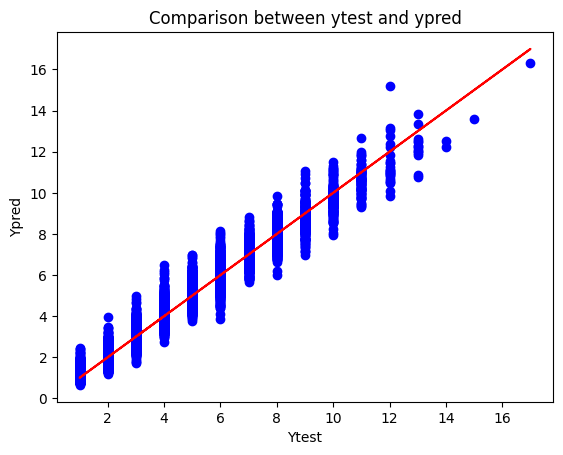

In [34]:
# Plotting
plt.scatter(y_test, y_pred, color='blue')  # Scatter plot with red color
plt.plot(y_test, y_test, color='red')     # Line plot with blue color (y = x line)

# Adding labels and title
plt.xlabel('Ytest')
plt.ylabel('Ypred')
plt.title('Comparison between ytest and ypred')

# Displaying the plot
plt.show()


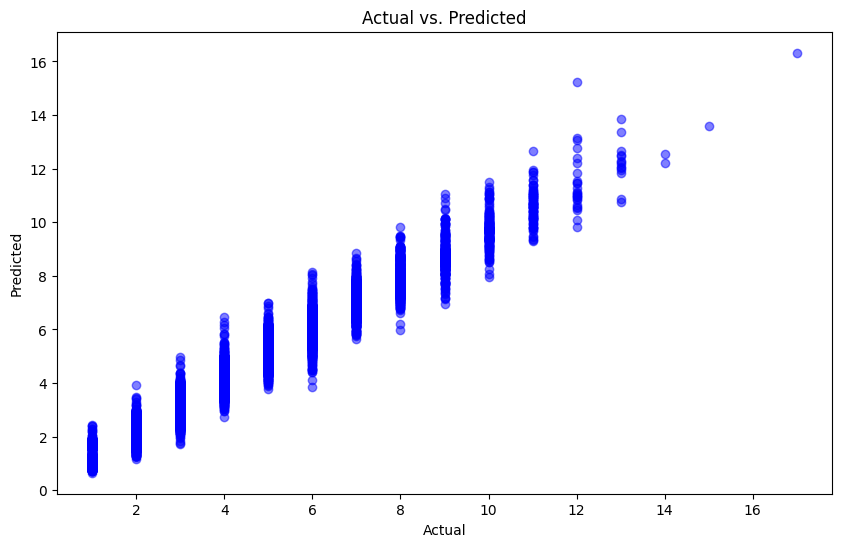

In [35]:
# Scatter plot
# Visualizes the relationship between the actual and predicted values. It helps to understand how well the model predicts the target variable across the range of its values. A perfect model would exhibit a diagonal line where actual values equal predicted values.

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

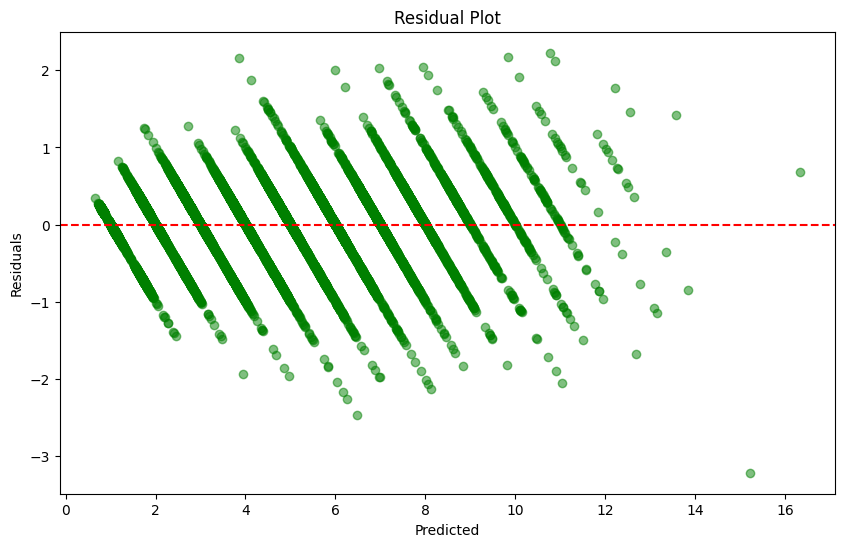

In [36]:
# Residual plot
#Residual plot: Shows the distribution of the errors (residuals) made by the model. It helps to assess whether the errors are randomly distributed around zero, which is an assumption of linear regression models. Patterns in the residuals may indicate systematic errors in the model.

residuals = y_test.values.flatten() - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='green', alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

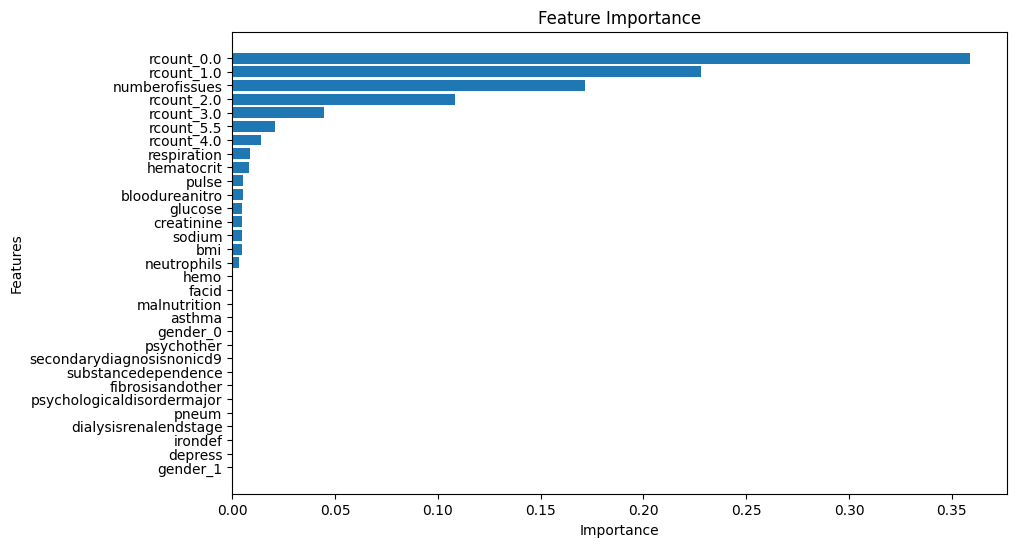

Index(['eid', 'vdate', 'rcount', 'gender', 'dialysisrenalendstage', 'asthma',
       'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor',
       'depress', 'psychother', 'fibrosisandother', 'malnutrition', 'hemo',
       'hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro',
       'creatinine', 'bmi', 'pulse', 'respiration',
       'secondarydiagnosisnonicd9', 'discharged', 'facid', 'lengthofstay',
       'numberofissues'],
      dtype='object')

In [38]:
# Feature importance plot
#Feature importance plot: Illustrates the importance of each feature in making predictions. It helps to identify which features have the most influence on the model's predictions. This information can be valuable for feature selection, model understanding, and potentially improving the model's performance.

feature_importance = xgb_regressor.feature_importances_
sorted_idx = feature_importance.argsort()
plt.figure(figsize=(10, 6))
plt.barh(x_train_encoded.columns[sorted_idx], feature_importance[sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()